# 2020-02-26: Data analysis of B4R/PJ020941.3 using GoDec-like method

In [1]:
# standard library
from pathlib import Path


# dependencies
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from jupyter_io import savefig_in_notebook
from scipy.ndimage import median_filter
from sklearn.decomposition import TruncatedSVD
from taniguchi_2021_analysis import (
    bin_channels,
    calibrate_intensity,
    load_data_xffts,
)
from tqdm import tqdm


# data directory
DATA = Path().resolve().parents[1] / "data"

## GoDec algorithm with modification

- sparse (S) is estimated by grouping

In [2]:
def estimate_S(X, L, k=100, s=5, pos_only=True):
    S = X - L
    S[S.scantype == "REF"] = 0.0
    spec = median_filter(S.sum("t"), s)

    if pos_only:
        spec = np.minimum(spec, 0)

    spec = np.abs(spec)

    for i in range(len(spec)-k):
        ch = np.nanargmin(spec)
        S[:,ch] = 0.0
        spec[ch] = np.nan

    return S


def estimate_L(X, S, n=10):
    R = X - S
    R0 = R.mean("t")

    model = TruncatedSVD(n)
    C = model.fit_transform(R - R0)
    P = model.components_
    L = xr.zeros_like(X) + C @ P + R0

    return L

## Load data

In [3]:
target = "PJ020941.3"
obsnum_cal = "086889"
obsnum_sci = "086890"
ifnum = "01"
sideband = "LSB"
T_amb = 273.0
ch_bin = 256

nc_tel_cal = DATA / "lmttpm_20191126_086889_00_01.nc"
nc_tel_sci = DATA / "lmttpm_20191126_086890_00_01.nc"
nc_cal = DATA / "xffts_20191126051026_086889_01.nc"
nc_sci = DATA / "xffts_20191126051059_086890_01.nc"

P_cal = load_data_xffts(nc_cal, nc_tel_cal, sideband).sortby("t")
P_sci = load_data_xffts(nc_sci, nc_tel_sci, sideband).sortby("t")

## Reduce data by chopper-wheel calibration and median baseline

In [4]:
T_cal = calibrate_intensity(P_sci, P_cal, T_amb)
T_cal = bin_channels(T_cal, ch_bin)
T_cal -= T_cal.median("ch")

100%|██████████| 30/30 [00:00<00:00, 32.50it/s]


## Reduce data by GoDec-like method

In [5]:
dP = P_sci - P_cal[P_cal.scanid == 0].mean("t")
dP = bin_channels(dP, ch_bin)
X = np.log(-dP/T_amb)

S = xr.zeros_like(X)

for i in tqdm(range(30)):
    L = estimate_L(X, S, n=5)
    S = estimate_S(X, L, k=25, s=5, pos_only=True)

T_cal_re = T_amb * (1-np.exp(X-L))
T_cal_re = T_cal_re[T_cal_re.scantype=="ON"]

print(f"Nonzero: {(S!=0).sum().values/S.size:.1%}")

100%|██████████| 30/30 [00:04<00:00,  6.73it/s]

Nonzero: 9.7%


## Make spectra and plot

In [6]:
weight = T_cal.std("ch") ** -2
spec = (weight * T_cal).sum("t") / weight.sum("t")

weight_re = T_cal_re.std("ch") ** -2
spec_re = (weight_re * T_cal_re).sum("t") / weight_re.sum("t")

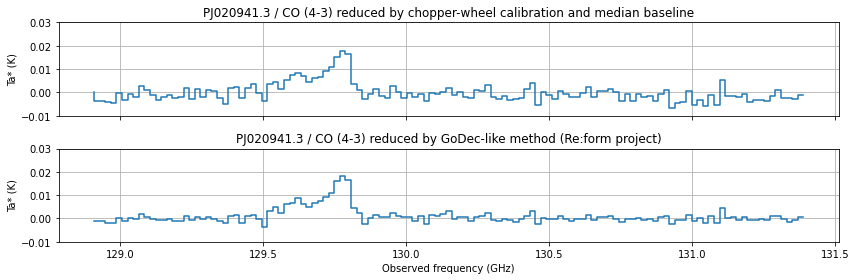

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

ax = axes[0]
ax.step(spec.ch, spec)
ax.set_title(f"{target} / CO (4-3) reduced by chopper-wheel calibration and median baseline")
ax.set_ylabel("Ta* (K)")
ax.set_xticklabels([])
ax.set_ylim(-0.01, 0.03)
ax.grid()

ax = axes[1]
ax.step(spec.ch, spec_re)
ax.set_title(f"{target} / CO (4-3) reduced by GoDec-like method (Re:form project)")
ax.set_xlabel("Observed frequency (GHz)")
ax.set_ylabel("Ta* (K)")
ax.set_ylim(-0.01, 0.03)
ax.grid()

fig.tight_layout()
savefig_in_notebook(fig, "PJ020941.3_CO54_spectra.pdf")

## Observed time vs noise level (standard deviation)

In [8]:
T_base = xr.concat([T_cal.loc[:, :129.4], T_cal.loc[:, 130.0:]], "ch")
T_base_re = xr.concat([T_cal_re.loc[:, :129.4], T_cal_re.loc[:, 130.0:]], "ch")

cumstd = (T_base.cumsum("t") / xr.ones_like(T_base).cumsum("t")).std("ch")
cumstd_re = (T_base_re.cumsum("t") / xr.ones_like(T_base_re).cumsum("t")).std("ch")
cumint = T_base.integtime.cumsum("t")

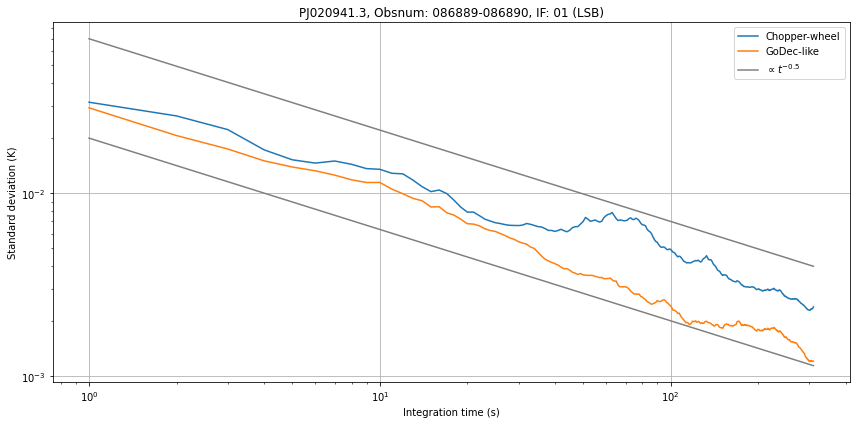

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(cumint, cumstd, label="Chopper-wheel")
ax.plot(cumint, cumstd_re, label="GoDec-like")
ax.plot(cumint, 0.02 * cumint**-0.5, c="gray")
ax.plot(cumint, 0.07 * cumint**-0.5, c="gray", label="$\propto t^{-0.5}$")

ax.set_title(f"{target}, Obsnum: {obsnum_cal}-{obsnum_sci}, IF: {ifnum} ({sideband})")
ax.set_xlabel("Integration time (s)")
ax.set_ylabel("Standard deviation (K)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid()

fig.tight_layout()
savefig_in_notebook(fig, "PJ020941.3_CO54_cumstd.pdf")